In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pickle
import kerastuner as kt

# Load Data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
# set random seed
random_seed = 8
tf.random.set_seed = random_seed
np.random.seed(random_seed)

# Exploratory Data Analysis

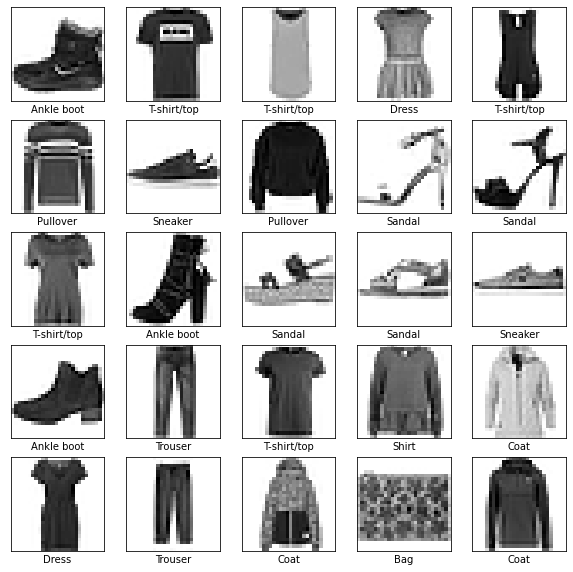

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

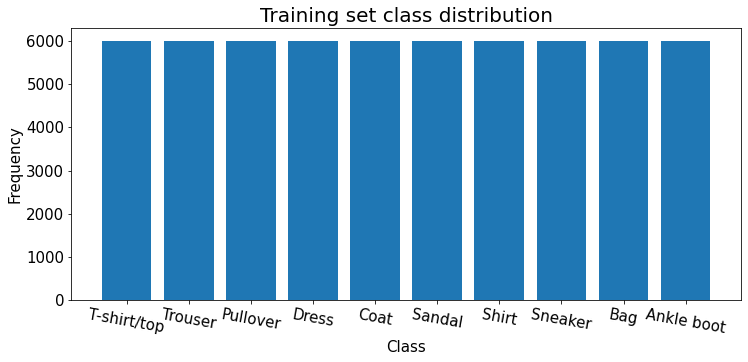

In [5]:
labels, counts = np.unique(train_labels.astype(np.int8), return_counts = True)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(class_names, counts, width = 0.8, align = "center")
ax.set_xlabel("Class", fontdict={"color":  "black", "size": 15} )
ax.set_ylabel("Frequency", fontdict={"color":  "black", "size": 15})
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'x', labelrotation=-10)
ax.set_title(label = "Training set class distribution", fontdict={"color":  "black", "size": 20})
plt.show()

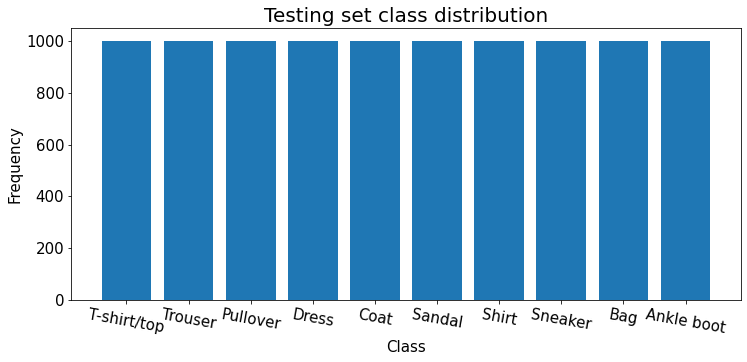

In [6]:
labels, counts = np.unique(test_labels.astype(np.int8), return_counts = True)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(class_names, counts, width = 0.8, align = "center")
ax.set_xlabel("Class", fontdict={"color":  "black", "size": 15} )
ax.set_ylabel("Frequency", fontdict={"color":  "black", "size": 15})
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'x', labelrotation=-10)
ax.set_title(label = "Testing set class distribution", fontdict={"color":  "black", "size": 20})
plt.show()

In [ ]:
# Plotting functions 

def plot_history(hs, epochs, metric):
    plt.rcParams['font.size'] = 16
    plt.figure(figsize=(15, 8))
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    #x_ticks = np.arange(0, epochs + 1, epochs / 10)
    #x_ticks [0] += 1
    #plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.clf()
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(15,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(classes))-0.5)
    plt.ylim(len(np.unique(classes))-0.5, -0.5)
    return ax

## Data Preprocessing

In [ ]:
def prepare_dataset():

  (traindev_x, traindev_y), (test_x, test_y) = (train_images, train_labels), (test_images, test_labels)

  train_x, dev_x, train_y, dev_y = train_test_split(traindev_x, traindev_y,
                                                  stratify=traindev_y,
                                                  random_state = random_seed, 
                                                  shuffle=True, 
                                                  test_size=0.10)
  # convert from integers to floats
  train_x = train_x.astype('float32')
  dev_x = dev_x.astype('float32')
  test_x = test_x.astype('float32')
  
  # normalize to range 0-1
  train_x = train_x / 255.0
  dev_x = dev_x / 255.0
  test_x = test_x / 255.0

  # one hot encode target values
  train_y = to_categorical(train_y)
  dev_y = to_categorical(dev_y)
  test_y = to_categorical(test_y)

  return train_x, dev_x, train_y, dev_y, test_x, test_y


# MODEL PREPARATION
***

## MLP

In [ ]:
#Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True,
                                   patience=5, verbose=1)

callback = [early_stop]

In [ ]:
#Prepare Dataset

train_x, dev_x, train_y, dev_y, test_x, test_y = prepare_dataset()
train_x = train_x.reshape((train_x.shape[0],784))
dev_x = dev_x.reshape((dev_x.shape[0],784))
test_x = test_x.reshape((test_x.shape[0], 784))

In [ ]:
#Destroy Old Oracle
!rm -rf tuning-mlp

### Tunable Model
def mlp_model_builder(hp):
  model = Sequential()
 
  
  model.add(Dense(units = hp.Int('dense-bot', min_value=50, max_value=350, step=50), input_shape=(784,), activation='relu'))
  for i in range(hp.Int('num_dense_layers', 1, 2)):
    model.add(Dense(units=hp.Int('dense_' + str(i), min_value=50, max_value=100, step=25), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2])))
  model.add(Dense(10,activation="softmax"))

  hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

  if hp_optimizer == 'Adam':
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer == 'SGD':
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
      nesterov=True
      momentum=0.9

  model.compile( optimizer=hp_optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Overload arguments with our custom metric.
tuner_mlp = kt.tuners.BayesianOptimization(
    mlp_model_builder,
    seed=random_seed,
    objective='val_loss',
    max_trials=30,
    directory='.',
    project_name='tuning-mlp')

In [ ]:
### Search Space 
tuner_mlp.search(train_x, train_y, epochs=50, batch_size=32, validation_data=(dev_x, dev_y), callbacks=callback)

Trial 30 Complete [00h 01m 13s]
val_loss: 0.29192450642585754

Best val_loss So Far: 0.2686508595943451
Total elapsed time: 01h 06m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_mlp_hyperparameters = tuner_mlp.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters.values

Best Hyper-parameters


{'Optimizer': 'SGD',
 'dense-bot': 350,
 'dense_0': 100,
 'dense_1': 50,
 'dropout_0': 0.1,
 'dropout_1': 0.0,
 'learning_rate': 0.001,
 'num_dense_layers': 2}

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(best_mlp_hyperparameters['dense-bot'], input_shape=(784,), activation='relu'))
for i in range(best_mlp_hyperparameters['num_dense_layers']):
  model_mlp.add(Dense(units=best_mlp_hyperparameters['dense_' +str(i)], activation='relu'))
  model_mlp.add(Dropout(rate=best_mlp_hyperparameters['dropout_' +str(i)]))
model_mlp.add(Dense(10,activation="softmax"))

model_mlp.compile(optimizer=best_mlp_hyperparameters['Optimizer'], 
                                                 loss='categorical_crossentropy', 
                                                 metrics=['accuracy'])
history_mlp= model_mlp.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(dev_x, dev_y), callbacks=callback)

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.1344 - accuracy: 0.6379 - val_loss: 0.5018 - val_accuracy: 0.8322
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5240 - accuracy: 0.8141 - val_loss: 0.4389 - val_accuracy: 0.8482
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4560 - accuracy: 0.8391 - val_loss: 0.4304 - val_accuracy: 0.8503
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4220 - accuracy: 0.8492 - val_loss: 0.3906 - val_accuracy: 0.8668
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3915 - accuracy: 0.8601 - val_loss: 0.3664 - val_accuracy: 0.8752
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3795 - accuracy: 0.8647 - val_loss: 0.3615 - val_accuracy: 0.8725
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3611 - accuracy: 0.8695 - val_loss: 0.3525 - val_ac

In [ ]:
print(model_mlp.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 350)               274750    
_________________________________________________________________
dense_29 (Dense)             (None, 100)               35100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                510       
Total params: 315,410
Trainable params: 315,410
Non-trainable params: 0
________________________________________________

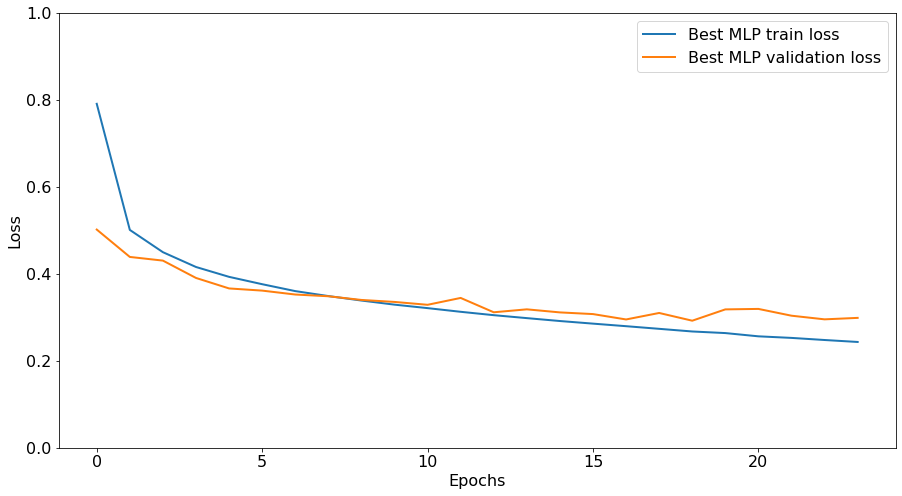

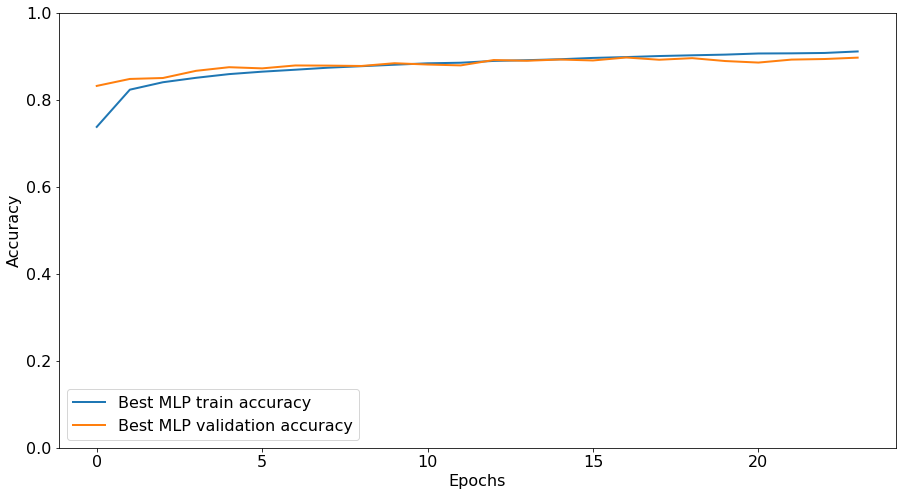

In [ ]:
plot_history(
    hs={
        'Best MLP': history_mlp
    },
    epochs=25,
    metric='loss')

plot_history(
    hs={
        'Best MLP': history_mlp
    },
    epochs=25,
    metric='accuracy')

In [ ]:
#Calculate accuracies
mlp_train_loss, mlp_train_acc = model_mlp.evaluate(train_x,  train_y, verbose=2)
print('\nTrain accuracy:', mlp_train_acc)

mlp_dev_loss, mlp_dev_acc = model_mlp.evaluate(dev_x,  dev_y, verbose=2)
print('\nValidation accuracy:', mlp_dev_acc)

mlp_test_loss, mlp_test_acc = model_mlp.evaluate(test_x,  test_y, verbose=2)
print('\nTest accuracy:', mlp_test_acc)

1688/1688 - 2s - loss: 0.2395 - accuracy: 0.9127

Train accuracy: 0.9126851558685303
188/188 - 0s - loss: 0.2923 - accuracy: 0.9030

Validation accuracy: 0.9030000276565552
313/313 - 0s - loss: 0.3317 - accuracy: 0.8823

Test accuracy: 0.8823000192642212


Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

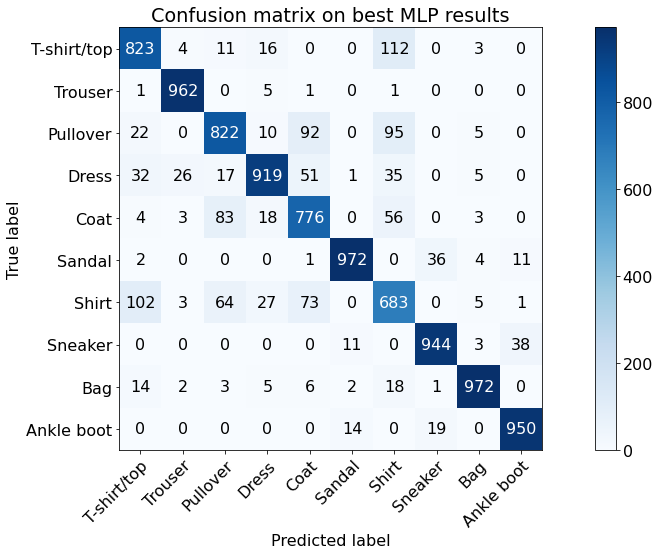

In [ ]:
predictions=model_mlp.predict(test_x)

plot_confusion_matrix(tf.argmax(predictions, axis = 1).numpy(), tf.argmax(test_y, axis = 1).numpy(),  classes=class_names,
                      title='Confusion matrix on best MLP results')
plt.show()

## CNN

In [ ]:
#Prepare Dataset

early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True,
                                   patience=4, verbose=1)

callback = [early_stop]

train_x, dev_x, train_y, dev_y, test_x, test_y = prepare_dataset()

train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
dev_x = dev_x.reshape((dev_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [ ]:
#Destroy Old Oracle
!rm -rf tuning-cnn

### Tunable Model
def model_builder(hp):
  model = Sequential()

  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))

  for i in range(hp.Int('num_blocks', 1, 2)):
      hp_padding=hp.Choice('padding_'+ str(i), values=['valid', 'same'])
      hp_filters=hp.Choice('filters_'+ str(i), values=[32, 64])

      model.add(Conv2D(hp_filters, (3, 3), padding=hp_padding, activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
      model.add(MaxPooling2D((2, 2)))
      model.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2])))

  model.add(Flatten())

  hp_units = hp.Int('units', min_value=25, max_value=150, step=25)
  model.add(Dense(hp_units, activation='relu', kernel_initializer='he_uniform'))
 
  model.add(Dense(10,activation="softmax"))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

  if hp_optimizer == 'Adam':
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  elif hp_optimizer == 'SGD':
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
      nesterov=True
      momentum=0.9

  model.compile( optimizer=hp_optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Overload arguments with our custom metric.
tuner_cnn = kt.tuners.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=100,
    directory='.',
    project_name='tuning-cnn')

In [ ]:
tuner_cnn.search(train_x, train_y, epochs=50, batch_size=32, validation_data=(dev_x, dev_y), callbacks=callback)

Trial 100 Complete [00h 01m 14s]
val_loss: 0.1958768665790558

Best val_loss So Far: 0.18872861564159393
Total elapsed time: 02h 36m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_cnn_model = tuner_cnn.get_best_models(1)[0]
print("Best CNN Model")
best_cnn_model.summary()

best_cnn_hyperparameters = tuner_cnn.get_best_hyperparameters(1)[0]
print("Best CNN Hyper-parameters")
best_cnn_hyperparameters.values

Best CNN Model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 313

{'Optimizer': 'Adam',
 'dropout_0': 0.2,
 'dropout_1': 0.2,
 'filters_0': 32,
 'filters_1': 64,
 'learning_rate': 0.01,
 'num_blocks': 2,
 'padding_0': 'same',
 'padding_1': 'same',
 'units': 150}

In [ ]:
model_cnn = Sequential()

model_cnn.add(Input(shape=(28, 28, 1)))

for i in range(best_cnn_hyperparameters['num_blocks']):
  hp_padding=best_cnn_hyperparameters['padding_'+ str(i)]
  hp_filters=best_cnn_hyperparameters['filters_'+ str(i)]

  model_cnn.add(Conv2D(hp_filters, (3, 3), padding=hp_padding, activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model_cnn.add(MaxPooling2D((2, 2)))
  model_cnn.add(Dropout(best_cnn_hyperparameters['dropout_'+ str(i)]))

model_cnn.add(Flatten())
model_cnn.add(Dense(best_cnn_hyperparameters['units'], activation='relu', kernel_initializer='he_uniform'))
 
model_cnn.add(Dense(10,activation="softmax"))

model_cnn.compile(optimizer=best_cnn_hyperparameters['Optimizer'], 
                                                 loss='categorical_crossentropy', 
                                                 metrics=['accuracy'])
print(model_cnn.summary())

history_cnn= model_cnn.fit(train_x, train_y, epochs=50, batch_size=32, validation_data=(dev_x, dev_y), callbacks=callback)

Epoch 1/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.5463 - accuracy: 0.8086 - val_loss: 0.2778 - val_accuracy: 0.8982
Epoch 2/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2797 - accuracy: 0.8949 - val_loss: 0.2403 - val_accuracy: 0.9158
Epoch 3/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2274 - accuracy: 0.9159 - val_loss: 0.1992 - val_accuracy: 0.9223
Epoch 4/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1918 - accuracy: 0.9284 - val_loss: 0.2097 - val_accuracy: 0.9243
Epoch 5/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1674 - accuracy: 0.9365 - val_loss: 0.2178 - val_accuracy: 0.9275
Epoch 6/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1442 - accuracy: 0.9444 - val_loss: 0.2052 - val_accuracy: 0.9270
Epoch 7/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1327 - accuracy: 0.9502 - val_loss: 0.2103 - val_accuracy:

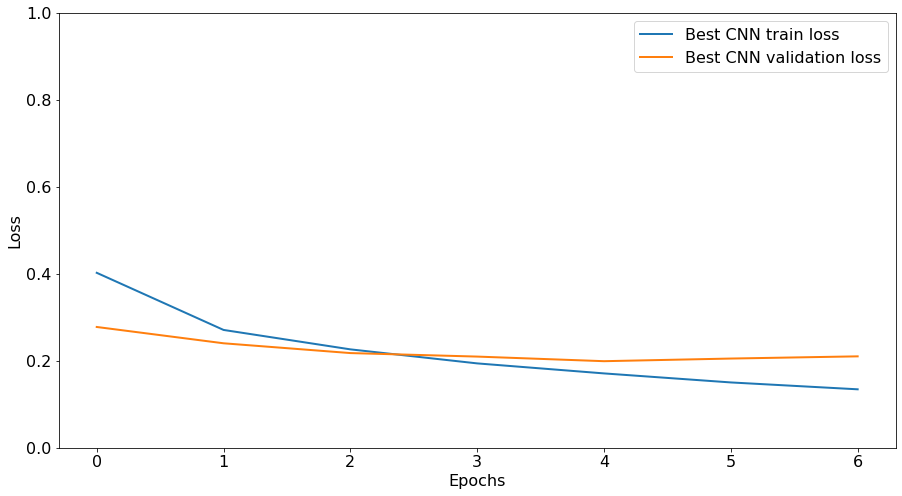

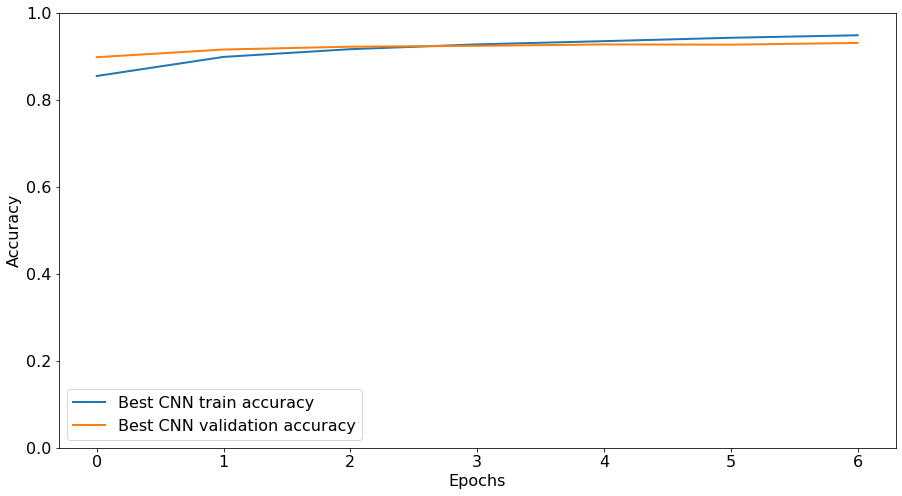

In [ ]:
plot_history(
    hs={
        'Best CNN': history_cnn
    },
    epochs=10,
    metric='loss')

plot_history(
    hs={
        'Best CNN': history_cnn
    },
    epochs=10,
    metric='accuracy')

In [ ]:
cnn_train_loss, cnn_train_acc = model_cnn.evaluate(train_x,  train_y, verbose=2)
print('\nTrain accuracy:', cnn_train_acc)

cnn_dev_loss, cnn_dev_acc = model_cnn.evaluate(dev_x,  dev_y, verbose=2)
print('\nValidation accuracy:', cnn_dev_acc)

cnn_test_loss, cnn_test_acc = model_cnn.evaluate(test_x,  test_y, verbose=2)
print('\nTest accuracy:', cnn_test_acc)

1688/1688 - 3s - loss: 0.1183 - accuracy: 0.9374

Train accuracy: 0.9373703408241272
188/188 - 0s - loss: 0.2077 - accuracy: 0.9275

Validation accuracy: 0.9275000095367432
313/313 - 1s - loss: 0.2325 - accuracy: 0.9200

Test accuracy: 0.9200000166893005


In [ ]:
predictions=model_cnn.predict(test_x)

plot_confusion_matrix(tf.argmax(predictions, axis = 1).numpy(), tf.argmax(test_y, axis = 1).numpy(),  classes=class_names,
                      title='Confusion matrix on best CNN results')
plt.show()

### Plot both models

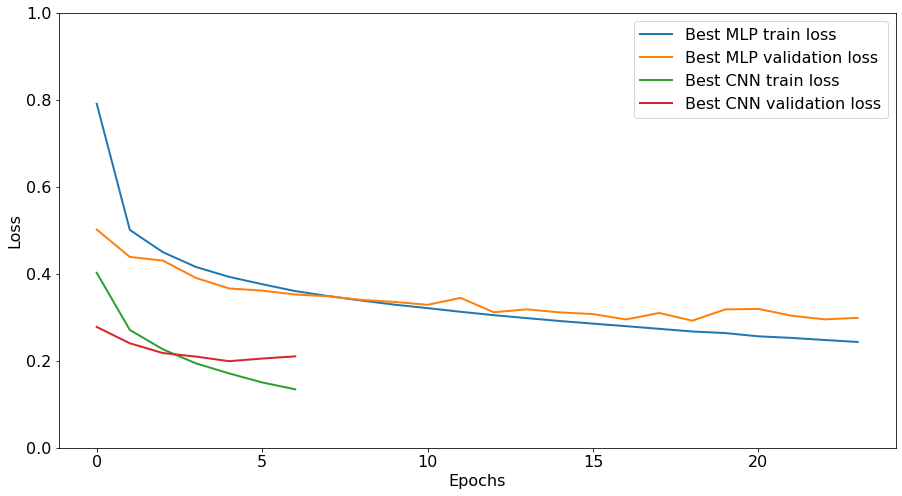

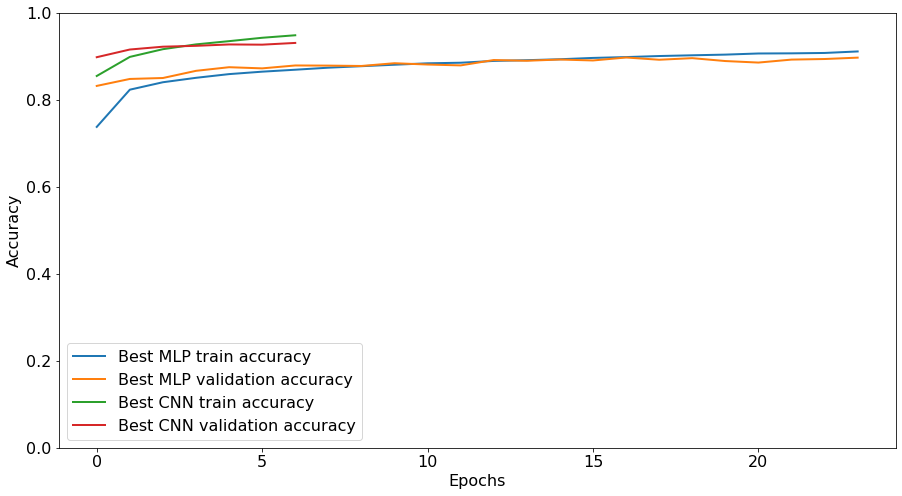

In [ ]:
plot_history(
    hs={
        'Best MLP': history_mlp,
        'Best CNN': history_cnn
    },
    epochs=25,
    metric='loss')

plot_history(
    hs={
        'Best MLP': history_mlp,
        'Best CNN': history_cnn
    },
    epochs=25,
    metric='accuracy')